# Assignment 2: Data Wrangling
### Joe Leonard (ymd3tv) - DS 3001

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)

In [5]:
import pandas as pd

# Loading in the Data
airbnb_data = pd.read_csv('./data/airbnb_hw.csv')

# Count Number of Missing Values Pre-Clean (This is to see if we mess up any values)
missing_values = airbnb_data['Price'].isna().sum()
print(f"Missing Values in Price Pre-Clean: {missing_values}")

# Removing Any Commas & Convert to Floats
airbnb_data['Price'] = airbnb_data['Price'].astype(str).str.replace(',', '').astype(float)

# Multiplying All Price Values by 1000 (This must happen as prices are $675,000, not $675)
airbnb_data['Price'] = airbnb_data['Price'] * 1000

# Adding in 2 Decimal Points (This is to keep theme with common pricing practices, this also may not work due to floats' structure in pandas)
airbnb_data['Price'].round(3)

# Count Number of Missing Values
missing_values = airbnb_data['Price'].isna().sum()
print(f"Missing Values in Price Post-Clean: {missing_values}")
print(airbnb_data['Price'].head())

Missing Values in Price Pre-Clean: 0
Missing Values in Price Post-Clean: 0
0    145000.0
1     37000.0
2     28000.0
3    199000.0
4    549000.0
Name: Price, dtype: float64


2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? 

In [25]:
# Loading in the Data
minn_data = pd.read_csv('./data/mn_police_use_of_force.csv')

# Finding Out Proportion of Missing Values (After analyzation, not much cleaning can be done, values are either 'Yes', 'No', or missing)
missing_proportion = minn_data['subject_injury'].isna().mean()
print(f"% of Missing Values: {missing_proportion:.2%}")

# Changing N/A Values to 'N/A' (This will allow the N/A values to show up in the cross-tabulation tables)
minn_data['subject_injury'] = minn_data['subject_injury'].replace({
    'Yes': 'Yes',
    'No': 'No',
    None : 'N/A'
})

# Creating the Cross-Tabulation Tables
cross_tab = pd.crosstab(
    minn_data['subject_injury'], 
    minn_data['force_type'], 
    margins = True, 
    margins_name = "Total"
)
print("Cross-Tab of 'subject_injury' and 'force_type':")
print(cross_tab)

% of Missing Values: 76.19%
Cross-Tab of 'subject_injury' and 'force_type':
force_type      Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury                                                    
N/A                 2          7051               1421        0   
No                  0          1093                131        2   
Yes                 2          1286                 41        0   
Total               4          9430               1593        2   

force_type      Gun Point Display  Improvised Weapon  Less Lethal  \
subject_injury                                                      
N/A                            27                 74           87   
No                             33                 34            0   
Yes                            44                 40            0   
Total                         104                148           87   

force_type      Less Lethal Projectile  Maximal Restraint Technique  \
subject_injury                     

In [26]:
import numpy as np

# Renaming 'N/A' to None for Parsing Purposes
minn_data['subject_injury'] = minn_data['subject_injury'].replace({
    'N/A' : None
})

# Removing Some Rows Based on Force Type (We can see some force types only have NAs, so we can remove these)
minn_data = minn_data[~minn_data['force_type'].isin(['Less Lethal', 'Maximal Restraint Technique'])]

# Forcing All Rows to Be 'Yes' (For the 'Baton' force type, we can see only 2/4 occurences are NA and then the other 2 are 'Yes', 
# so we can assume these NAs are 'Yes')
minn_data.loc[minn_data['force_type'] == 'Baton', 'subject_injury'] = 'Yes'

# Using Yes/No Proportion to Assume NAs for Less Occuring Force Types (This may not be 100% fool proof but for 'Gun Point Display' and 
# 'Improvised Weapon', we have equal amounts of missing and noln-missing data so we can assume the same distribution would occur)
def impute_na(group):
    proportions = group.value_counts(normalize=True, dropna=True)
    return group.apply(lambda x: np.random.choice(proportions.index, p=proportions.values) if pd.isna(x) else x)

target_force_types = ['Gun Point Display', 'Improvised Weapon']

for force_type in target_force_types:
    mask = (minn_data['force_type'] == force_type) & minn_data['subject_injury'].isna()
    if mask.any():
        group_values = minn_data.loc[minn_data['force_type'] == force_type, 'subject_injury']
        minn_data.loc[mask, 'subject_injury'] = impute_na(group_values)

# Repopulating the Missing Values % and Cross-Tab Tables
missing_proportion = minn_data['subject_injury'].isna().mean()
print(f"% of Missing Values: {missing_proportion:.2%}")

minn_data['subject_injury'] = minn_data['subject_injury'].replace({
    'Yes': 'Yes',
    'No': 'No',
    None : 'N/A'
})

cross_tab = pd.crosstab(
    minn_data['subject_injury'], 
    minn_data['force_type'], 
    margins = True, 
    margins_name = "Total"
)
print("Cross-Tab of 'subject_injury' and 'force_type':")
print(cross_tab)

% of Missing Values: 74.90%
Cross-Tab of 'subject_injury' and 'force_type':
force_type      Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury                                                    
N/A                 0          7051               1421        0   
No                  0          1093                131        2   
Yes                 4          1286                 41        0   
Total               4          9430               1593        2   

force_type      Gun Point Display  Improvised Weapon  Less Lethal Projectile  \
subject_injury                                                                 
N/A                             0                  0                       0   
No                             45                 67                       1   
Yes                            59                 81                       2   
Total                         104                148                       3   

force_type      Police K9 Bite  Taser  T

3. Dummy variable: For the pretrial data covered in the lecture, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.

In [42]:
# Loading in the Data
justice_data = pd.read_parquet("./data/justice_data.parquet")

# Show Column Issues (This is because it is a parquet file, so I couldn't analyze it in Excel, Sheets, etc.)
print(justice_data['WhetherDefendantWasReleasedPretrial'].value_counts(dropna=False))

WhetherDefendantWasReleasedPretrial
1    19154
0     3801
9       31
Name: count, dtype: int64


In [43]:
# Only Allow 1s or 0s, Everything Else Should Be np.nan
justice_data['WhetherDefendantWasReleasedPretrial'] = justice_data['WhetherDefendantWasReleasedPretrial'].replace(1, 'Yes')
justice_data['WhetherDefendantWasReleasedPretrial'] = justice_data['WhetherDefendantWasReleasedPretrial'].replace(0, 'No')
justice_data['WhetherDefendantWasReleasedPretrial'] = justice_data['WhetherDefendantWasReleasedPretrial'].replace(9, np.nan)

# Display Cleaned Column
print(justice_data['WhetherDefendantWasReleasedPretrial'].value_counts(dropna=False))

WhetherDefendantWasReleasedPretrial
Yes    19154
No      3801
NaN       31
Name: count, dtype: int64


4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [ ]:
##########################################

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.

In [98]:
import xlrd

# Loading in the Data
shark_data = pd.read_excel('./data/shark_data.xls')
print(shark_data.head)

<bound method NDFrame.head of                      Date    Year        Type             Country  \
0     2025-01-23 00:00:00  2025.0  Unprovoked           Australia   
1     2025-01-22 00:00:00  2025.0  Unprovoked           Australia   
2     2025-01-11 00:00:00  2025.0    Provoked                 USA   
3     2025-01-02 00:00:00  2025.0  Unprovoked       New Caledonia   
4     2025-01-02 00:00:00  2025.0  Unprovoked           Australia   
...                   ...     ...         ...                 ...   
6987          Before 1903     0.0  Unprovoked           AUSTRALIA   
6988          Before 1903     0.0  Unprovoked           AUSTRALIA   
6989            1900-1905     0.0  Unprovoked                 USA   
6990            1883-1889     0.0  Unprovoked              PANAMA   
6991            1845-1853     0.0  Unprovoked  CEYLON (SRI LANKA)   

                  State                                 Location  \
0     Western Australia                           Shipwreck Cove   
1    

2. Drop any columns that do not contain data.

In [99]:
# Print Shape Before Deletion
print(f"Shark Data Shape: {shark_data.shape}")

# Delete NAs and Print Shape
shark_data = shark_data.dropna(axis=1, how='all')
print(f"Updated Shark Data Shape: {shark_data.shape}")

Shark Data Shape: (6992, 23)
Updated Shark Data Shape: (6992, 23)


3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?


Year Range of Attacks: (1940, 2025)
Trend: Constant


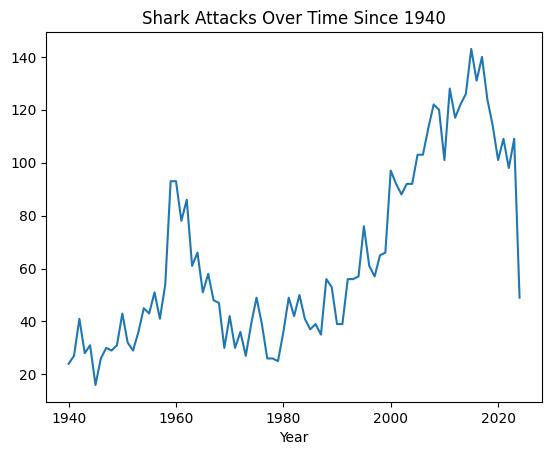

In [100]:
# Making All Year Values Numeric
shark_data['Year'] = pd.to_numeric(shark_data['Year'], errors='coerce')

# Filtering for Attacks Since 1940
shark_data_filtered = shark_data[shark_data['Year'] >= 1940]

# Showing the Range of Values
year_range = round(shark_data_filtered['Year'].min()), round(shark_data_filtered['Year'].max() - 1)
print("\nYear Range of Attacks:", year_range)

# Analyzing the Trends Over Time
shark_data_filtered_2 = shark_data_filtered[~shark_data_filtered['Year'].isin([2025, 2026])]
attacks_by_year = shark_data_filtered_2['Year'].value_counts().sort_index()
attacks_by_year.plot(kind='line', title='Shark Attacks Over Time Since 1940')

if attacks_by_year.is_monotonic_increasing:
    trend = "Increasing"
elif attacks_by_year.is_monotonic_decreasing:
    trend = "Decreasing"
else:
    trend = "Constant"
print("Trend:", trend)


4. Clean the Age variable and make a histogram of the ages of the victims.

C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\2106271717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_filtered['Age'] = pd.to_numeric(shark_data_filtered['Age'], errors='coerce')


Age
NaN     1899
17.0     148
15.0     141
20.0     137
18.0     136
        ... 
84.0       1
87.0       1
1.0        1
81.0       1
78.0       1
Name: count, Length: 82, dtype: int64


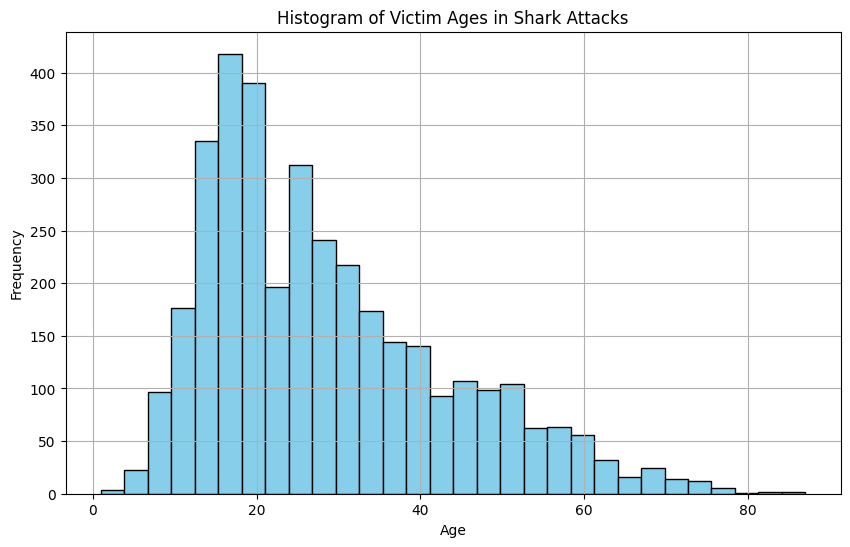

In [101]:
import matplotlib.pyplot as plt

# Converting Age to Numeric (This causes around 140 values to turn into NAs)
shark_data_filtered['Age'] = pd.to_numeric(shark_data_filtered['Age'], errors='coerce')
print(shark_data_filtered['Age'].value_counts(dropna=False))

# Dropping Rows w NA as Age
shark_data_clean = shark_data_filtered.dropna(subset=['Age'])

# Creating the Histogram
plt.figure(figsize=(10, 6))
plt.hist(shark_data_clean['Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Victim Ages in Shark Attacks')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

5. What proportion of victims are male?

In [102]:
# Declaring Valid Types and Making All Else Unknown
valid_types = ['M', 'F', 'Unknown']
shark_data_clean['Sex'] = shark_data_clean['Sex'].apply(lambda x: x if x in valid_types else 'Unknown')

# Calculating the Proportion of Male Victims
male_victims = shark_data_clean[shark_data['Sex'] == 'M']
total_victims = shark_data_clean.shape[0]
proportion_male = round(male_victims.shape[0] / total_victims, 3)
print("\nProportion of Male Victims:", proportion_male)


Proportion of Male Victims: 0.837


C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\1263807509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['Sex'] = shark_data_clean['Sex'].apply(lambda x: x if x in valid_types else 'Unknown')
C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\1263807509.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_victims = shark_data_clean[shark_data['Sex'] == 'M']


6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?

In [103]:
# Converting All Type Values to a String
shark_data_clean['Type'] = shark_data_clean['Type'].astype(str)

# Declaring Valid Types and Making All Else Unknown
valid_types = ['Provoked', 'Unprovoked', 'Unknown']
shark_data_clean['Type'] = shark_data_clean['Type'].apply(lambda x: x if x in valid_types else 'Unknown')

# Calculating the Proportion of Unprovoked Attacks
unprovoked_attacks = shark_data_clean[shark_data['Type'] == 'Unprovoked']
total_attacks = shark_data_clean.shape[0]
proportion_unprovoked = round(unprovoked_attacks.shape[0] / total_attacks, 3)
print("\nProportion of Unprovoked Attacks:", proportion_unprovoked)


Proportion of Unprovoked Attacks: 0.831


C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\863007790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['Type'] = shark_data_clean['Type'].astype(str)
C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\863007790.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['Type'] = shark_data_clean['Type'].apply(lambda x: x if x in valid_types else 'Unknown')
C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\863007790.py:9: UserWarning: Boolean Series key wi

7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.

In [104]:
# Declaring Valid Types and Making All Else Unknown
valid_values = ['Y', 'N', 'Unknown']
shark_data_clean['Fatal Y/N'] = shark_data_clean['Fatal Y/N'].apply(lambda x: x if x in valid_values else 'Unknown')

# Inspecting the Column
print("\nUnique Values in the 'Fatal Y/N' Column")
print(shark_data_clean['Fatal Y/N'].value_counts(dropna=False))


Unique Values in the 'Fatal Y/N' Column
Fatal Y/N
N          2819
Y           518
Unknown     222
Name: count, dtype: int64


C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\898797737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['Fatal Y/N'] = shark_data_clean['Fatal Y/N'].apply(lambda x: x if x in valid_values else 'Unknown')


8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?

In [105]:
# Filter for Unprovoked Attacks
unprovoked_data = shark_data_clean[shark_data_clean['Type'] == 'Unprovoked']

# Calculate the Number of Attacks by Sex
unprovoked_by_sex = round(unprovoked_data['Sex'].value_counts(normalize=True), 2)

print("Proportion of Unprovoked Attacks on Men and Women:")
print(unprovoked_by_sex)

Proportion of Unprovoked Attacks on Men and Women:
Sex
M          0.83
F          0.16
Unknown    0.01
Name: proportion, dtype: float64


In [106]:
# Filter for Provoked Attacks
provoked_data = shark_data_clean[shark_data_clean['Type'] == 'Provoked']

# Calculate the Proportion of Fatal Attacks by Type
fatal_provoked = round(provoked_data['Fatal Y/N'].value_counts(normalize=True).get('Y', 0), 2)
fatal_unprovoked = round(unprovoked_data['Fatal Y/N'].value_counts(normalize=True).get('Y', 0), 2)

print(f"Proportion of Fatal Attacks in Provoked Attacks: {fatal_provoked}")
print(f"Proportion of Fatal Attacks in Unprovoked Attacks: {fatal_unprovoked}")

Proportion of Fatal Attacks in Provoked Attacks: 0.03
Proportion of Fatal Attacks in Unprovoked Attacks: 0.16


In [107]:
# Calculate the Proportion of Fatal Attacks by Sex
fatal_by_sex = round(shark_data_clean.groupby('Sex')['Fatal Y/N'].value_counts(normalize=True).unstack().get('Y', 0), 2)

print("Proportion of Fatal Attacks for Male and Female Victims:")
print(fatal_by_sex)

Proportion of Fatal Attacks for Male and Female Victims:
Sex
F          0.13
M          0.15
Unknown    0.20
Name: Y, dtype: float64


#### To be honest, I've never thought too much of sharks. Growing up on Long Island, I've always heard of different interactions with them and most of them have not been fatal. It is evident that men are more likely to be attacked which urks me a bit, but I've never heard of an actual situation where someone has encountered a shark and it has ended badly. That being said, I bet if I were to come across one in the ocean, I would be pretty frightened and have 0 survival skills in the moment.  

9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

In [108]:
# Separating 'Species' Column into Lists of Words
shark_data_clean['Species_split'] = shark_data_clean['Species '].fillna('').str.split()

# Check if 'White' and 'Shark' is in the List
shark_data_clean['White_Shark_Attack'] = shark_data_clean['Species_split'].apply(
    lambda x: 'White' in [species.strip().title() for species in x] and 'Shark' in [species.strip().title() for species in x]
)

# Calculate the Proportion of Attacks by White Sharks
proportion_white_sharks = round(shark_data_clean['White_Shark_Attack'].mean(), 2)
print(f"\nProportion of Attacks Attributed to White Sharks: {proportion_white_sharks}")


Proportion of Attacks Attributed to White Sharks: 0.07


C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\1890692047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['Species_split'] = shark_data_clean['Species '].fillna('').str.split()
C:\Users\Joe Leonard\AppData\Local\Temp\ipykernel_10392\1890692047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shark_data_clean['White_Shark_Attack'] = shark_data_clean['Species_split'].apply(


**Q3.** Open the "tidy_data.pdf" document in the repo, which is a paper called Tidy Data by Hadley Wickham.

  1. Read the abstract. What is this paper about?
  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
  4. Read Section 2.2. How does Wickham define values, variables, and observations?
  5. How is "Tidy Data" defined in section 2.3?
  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?
  8. Read Section 6. What is the "chicken-and-egg" problem with focusing on tidy data? What does Wickham hope happens in the future with further work on the subject of data wrangling?

**Q4.** Many important datasets contain a race variable, typically limited to a handful of values often including Black, White, Asian, Latino, and Indigenous. This question looks at data gathering efforts on this variable by the U.S. Federal government.

1. How did the most recent US Census gather data on race?
2. Why do we gather these data? What role do these kinds of data play in politics and society? Why does data quality matter?
3. Please provide a constructive criticism of how the Census was conducted: What was done well? What do you think was missing? How should future large scale surveys be adjusted to best reflect the diversity of the population? Could some of the Census' good practices be adopted more widely to gather richer and more useful data?
4. How did the Census gather data on sex and gender? Please provide a similar constructive criticism of their practices.
5. When it comes to cleaning data, what concerns do you have about protected characteristics like sex, gender, sexual identity, or race? What challenges can you imagine arising when there are missing values? What good or bad practices might people adopt, and why?
6. Suppose someone invented an algorithm to impute values for protected characteristics like race, gender, sex, or sexuality. What kinds of concerns would you have?